In [1]:
import re
import json as js
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Reading data

In [ ]:
#with open('./review_train.json','r') as f:
#    lines = f.readlines()
#raw = list(map(js.loads,lines))
#raw_review = pd.DataFrame(raw)

In [ ]:
#raw_review.head()

In [ ]:
#raw_review.shape

In [ ]:
#all_text = raw_review[['text','stars']]

In [ ]:
#all_text.shape

In [ ]:
#all_text.to_csv('all_review.csv',index=False)

# If csv

In [2]:
raw_train_data = pd.read_csv('./all_review.csv')

In [3]:
raw_train_data.head()

,text,stars
0,Total bill for this horrible service? Over $8G...,1.0
1,I *adore* Travis at the Hard Rock's new Kelly ...,5.0
2,I have to say that this office really has it t...,5.0
3,Went in for a lunch. Steak sandwich was delici...,5.0
4,Today was my second out of three sessions I ha...,1.0


In [4]:
raw_train_data_new = raw_train_data[raw_train_data['text'].notnull()] 

In [5]:
raw_train_data_new = raw_train_data_new[raw_train_data_new['stars'].notnull()] 

In [6]:
raw_train_data_new.shape

(5364624, 2)

In [7]:
raw_train_data_new.index = range(raw_train_data_new.shape[0])

# EDA

In [10]:
lst = []
for i in range(raw_train_data_new.shape[0]):
    lst.append(len(raw_train_data_new['text'][i].split()))

In [11]:
lst[:5]

[39, 274, 109, 68, 673]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


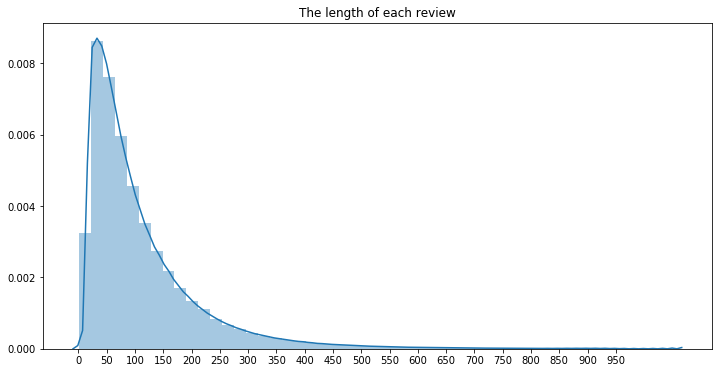

In [91]:
f, ax= plt.subplots(figsize = (12,6))
sns.distplot(lst)
plt.title('The length of each review')
plt.xticks(range(0,1000,50))
plt.show()

In [13]:
lst1 = [var for var in raw_train_data_new['stars']]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


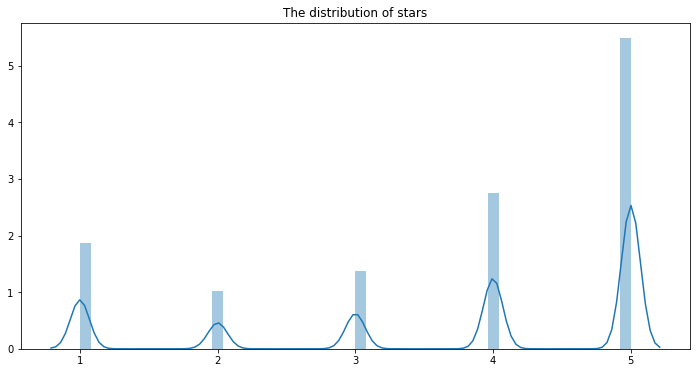

In [102]:
f, ax= plt.subplots(figsize = (12,6))
sns.distplot(lst1)
plt.title('The distribution of stars')
plt.show()

# Testing data

In [15]:
with open('./review_test.json','r') as f:
    lines = f.readlines()
raw = list(map(js.loads,lines))
raw_test_data = pd.DataFrame(raw)

In [16]:
raw_test_data = pd.read_csv('./raw_test_review.csv', low_memory=False)

In [17]:
raw_test_data.head()

,KaggleID,business_id,date,text
0,1,85246,2015-01-18 14:04:18,I was really looking forward to visiting after...
1,2,140371,2015-04-01 16:30:00,I love chinese food and I love mexican food. W...
2,3,148359,2017-03-27 01:14:37,"Our family LOVES the food here. Quick, friendl..."
3,4,133056,2017-05-13 10:41:43,If you are looking for the best pierogies in P...
4,5,121957,2012-11-06 03:41:43,"Great food, great service. Obviously fried chi..."


In [18]:
X_test = raw_test_data['text']

In [19]:
X_test.shape

(1321274,)

In [20]:
X_test.iloc[3]

"If you are looking for the best pierogies in Pittsburgh, this is your place. There are a few small tables outside but most of the business is carry out. Pierogies Plus wins Best Pierogies every year. Why? Because the owner is from Poland and she is making the real deal pierogies. The best part is that they are hand pinched by a group of older Polish and Hungarian women. \nThe biggest seller is potato and cheese but they sell many flavors. They are like plump pillows of softness. You can buy them buy the dozen. You can get them cold to take home and freeze or warm and ready to eat. The warm ones are served with butter and onions.  It's definitely a comfort food. The best part is that they ship internationally. Yes, they are that good."

# 100w

In [21]:
pd_first = raw_train_data_new.sample(frac=0.2,random_state=123)

In [22]:
pd_first.index = range(pd_first.shape[0])

In [23]:
pd_first.shape

(1072925, 2)

In [24]:
pd_first.head()

,text,stars
0,"Fantastic, friendly staff offered me a sample ...",5.0
1,I am a BIG fan of the Settebello location down...,4.0
2,what an amazing park! the ball fields are grea...,5.0
3,Across the street from the widely acclaimed Ve...,5.0
4,Stopped here after a long day of helping move ...,5.0


In [25]:
X_train =pd_first['text']

In [26]:
X_train.shape

(1072925,)

In [27]:
X_train.iloc[1072924]

'Awesome!!!  This smoothie bar and fitness club is owned and operated by people who are committed to the health and well being of their customer. \r\n\r\nGreat teas and healthy shakes that give you energy and fulfills your dietary needs for most of the day. You can easily spend $7 and replace breakfast and an expensive ( unhealthy) lunch.  \r\n\r\nThe owners believe in nutrition and fitness. They offer a complete and individual analysis of ones fitness goals and tailor your workout  accordingly. \r\n\r\nThis is not a big box gym where your membership fees are going to high overhead and corporate profits. You are going to change your life in a comfortable and supportive environment or your going to enjoy one of fifty or so delicious shakes and feel good about it.'

In [28]:
y_train = pd_first['stars']

In [29]:
y_train.shape

(1072925,)

# Onehot

In [31]:
ohe = OneHotEncoder()

In [34]:
y_ohe = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [35]:
y_ohe

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [36]:
y_ohe.shape

(1072925, 5)

# Tokenize

In [37]:
frame = [X_train, X_test]

In [38]:
X_all = pd.concat(frame)

In [39]:
X_all.shape

(2394199,)

In [40]:
X_all.head()

0    Fantastic, friendly staff offered me a sample ...
1    I am a BIG fan of the Settebello location down...
2    what an amazing park! the ball fields are grea...
3    Across the street from the widely acclaimed Ve...
4    Stopped here after a long day of helping move ...
Name: text, dtype: object

In [41]:
tokenizer = Tokenizer(num_words=20000, lower=True)

In [42]:
tokenizer.fit_on_texts(X_all)

In [43]:
tk_raw = tokenizer.texts_to_sequences(X_all)

In [44]:
tk_raw_final = pad_sequences(tk_raw, maxlen=200)

In [45]:
tk_train = tk_raw_final[:1072925]

In [46]:
tk_train.shape

(1072925, 200)

In [48]:
tk_train[1072924,]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,   205,    16,  2205,   157,     2,  2248,
         676,     9,  1487,     2,  4889,    76,   109,   125,    28,
        6600,     5,     1,  1483,     2,    85,   183,     7,    49,
         189,    13,    13,    36,  2514,     2,   914,  2816,    14,
         163,    20,  2014,     2,    68,  5789,   531,    10,   179,
           7,     1,   131,    20,    73,   988,   809,   495,     2,
        1740,   285,     2,    56,   542,  7039,   195,    13,    13,
           1,   905,

In [49]:
len(tk_train)

1072925

In [50]:
len(y_train)

1072925

In [51]:
tk_test = tk_raw_final[1072925:]

In [52]:
tk_test[3,]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    40,    20,    28,   214,    10,     1,    86,  6882,
          11,  1345,    16,     9,    68,    30,    37,    28,     4,
         158,   191,   404,   377,    19,   179,     7,     1,   290,
           9,  1604,    39,  6882,   470,  6943,    86,  6882,   172,
         405,   266,    77,     1,   388,     9,    50,     2,    63,
           9,   491,     1,   503,   439,  6882,     1,    86,   397,
           9,    14,    17,    28,   695,    76,     4,   482,     7,
        1447,  1695,

In [53]:
len(tk_test)

1321274

# LSTM(MSE)

In [68]:
maxlen = 200
max_features = 20000
embedding_size = 128

In [69]:
inp = Input(shape=(maxlen,))

In [70]:
x = Embedding(max_features, embedding_size)(inp)

In [71]:
x = LSTM(64)(x)

In [72]:
x = Dense(32, activation='relu')(x)

In [73]:
x = Dropout(0.5)(x)

In [74]:
x = Dense(1, activation='linear')(x)

In [75]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='mean_squared_error',
                  optimizer='adam',
             metrics=['accuracy'])

In [76]:
model.fit(tk_train, y_train, batch_size=32, epochs=1)

Epoch 1/1
1072925/1072925 [==============================] - 4026s 4ms/step - loss: 0.6525 - acc: 0.5332


In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,611,521
Trainable params: 2,611,521
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.save('last_final_mse.h5')

# LSTM(CROSS_ENTROPY)

In [79]:
maxlen = 200
max_features = 20000
embedding_size = 128

In [80]:
inp = Input(shape=(maxlen,))

In [81]:
x = Embedding(max_features, embedding_size)(inp)

In [82]:
x = LSTM(64)(x)

In [83]:
x = Dense(32, activation='relu')(x)

In [84]:
x = Dropout(0.5)(x)

In [85]:
x = Dense(5, activation='softmax')(x)

In [86]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
             metrics=['accuracy'])

In [87]:
model.fit(tk_train, y_ohe, batch_size=32, epochs=1)

Epoch 1/1
1072925/1072925 [==============================] - 4061s 4ms/step - loss: 0.7698 - acc: 0.6810


In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 2,611,653
Trainable params: 2,611,653
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.save('last_final_ce.h5')

# Predict

In [90]:
y_pre = model.predict(tk_test, verbose=1)

1321274/1321274 [==============================] - 804s 608us/step


# If softmax

In [93]:
y_pre[:5]

array([[1.06180780e-01, 3.42368305e-01, 4.38934177e-01, 1.04217187e-01,
        8.29943549e-03],
       [9.05667432e-03, 2.31842697e-01, 6.85215533e-01, 7.31521174e-02,
        7.32984277e-04],
       [5.13815763e-08, 4.43464160e-07, 9.74483613e-04, 1.23238005e-01,
        8.75787020e-01],
       [1.16248939e-05, 7.34999048e-05, 1.40101425e-02, 3.07483554e-01,
        6.78421199e-01],
       [7.57580801e-06, 6.74943731e-05, 1.60139017e-02, 3.59154612e-01,
        6.24756396e-01]], dtype=float32)

In [94]:
y_classes = y_pre.argmax(axis=-1)+1

In [95]:
y_classes[:5]

array([3, 3, 5, 5, 5], dtype=int64)

# Final result

In [96]:
pd_predict_final = pd.DataFrame(columns=['Id','Expected'])

In [97]:
pd_predict_final['Id'] = raw_test_data['KaggleID']

In [98]:
pd_predict_final['Expected'] = y_classes #y_pre(regression)

In [99]:
pd_predict_final.head()

,Id,Expected
0,1,3
1,2,3
2,3,5
3,4,5
4,5,5


In [100]:
pd_predict_final.shape

(1321274, 2)

In [101]:
#pd_predict_final.to_csv('final_pred_ce.csv',index=False)